<a href="https://colab.research.google.com/github/Anujj-4r4/Anujj-4r4/blob/main/project_ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

In [5]:
# Load the dataset
df = pd.read_csv('/content/nvdia_stock1.csv')  # Adjust path as needed
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [6]:
# Calculate Simple Moving Averages (SMA) and Exponential Moving Averages (EMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

In [7]:
# Calculate Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [8]:
# Drop NaN values created by indicators
df.dropna(inplace=True)

In [9]:
# Select relevant columns for analysis
data = df[['Close', 'SMA_20', 'EMA_20', 'RSI']]

In [10]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
# Split the data into training and testing sets
training_data_len = int(len(data) * 0.8)
train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:]

In [12]:
# Create the training dataset
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 0])  # Target is the 'Close' price

x_train, y_train = np.array(x_train), np.array(y_train)


In [13]:
# Create the test dataset
x_test = []
y_test = data['Close'].iloc[training_data_len:].values
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i])

x_test = np.array(x_test)


In [14]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))  # Add Dropout to reduce overfitting
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Train the model with Early Stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stopping])

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0048
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 5.3614e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 5.7391e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 3.7872e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.1353e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 3.4987e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 2.8968e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 2.8457e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 3.0877e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 2.5909e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 2.9054e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.5541e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.6841e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 2.2355e-04
Epoch 15/50
61/61 ━

In [17]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], 3))], axis=1)
)[:, 0]  # Only take the 'Close' column after inverse transform

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


# Calculate RMSE
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print(f"RMSE: {rmse}")

<ipython-input-18-069e41ac2b4b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


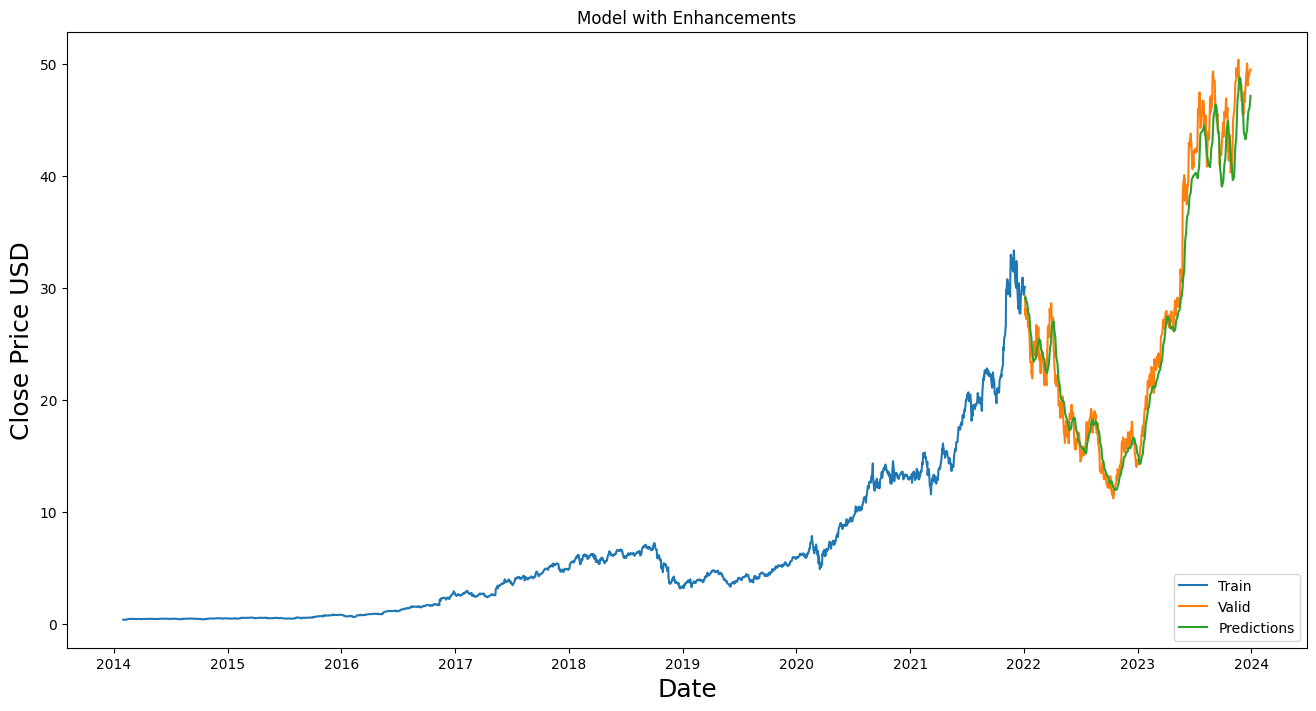

In [18]:
# Visualize the results
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title('Model with Enhancements')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Valid')
plt.plot(valid['Predictions'], label='Predictions')
plt.legend(loc='lower right')
plt.show()

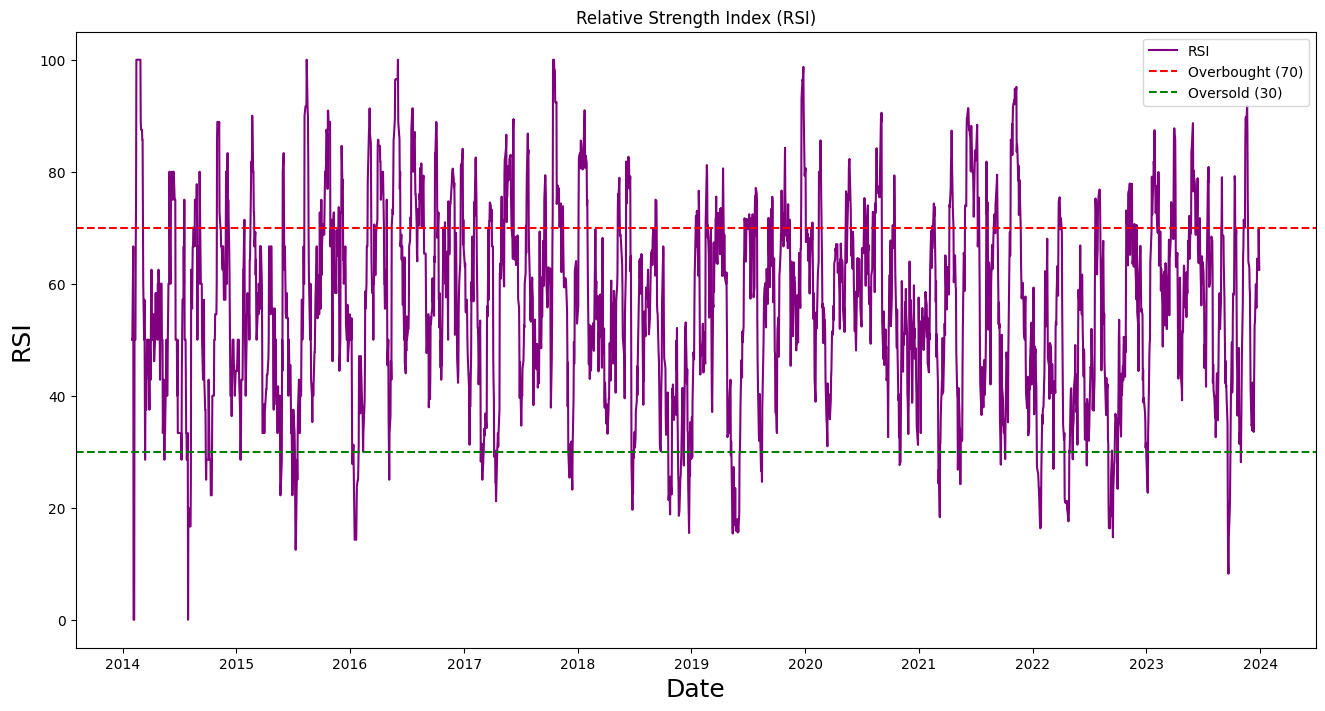

In [19]:
# Plot RSI
plt.figure(figsize=(16, 8))
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('RSI', fontsize=18)
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', label='Oversold (30)')
plt.legend()
plt.show()

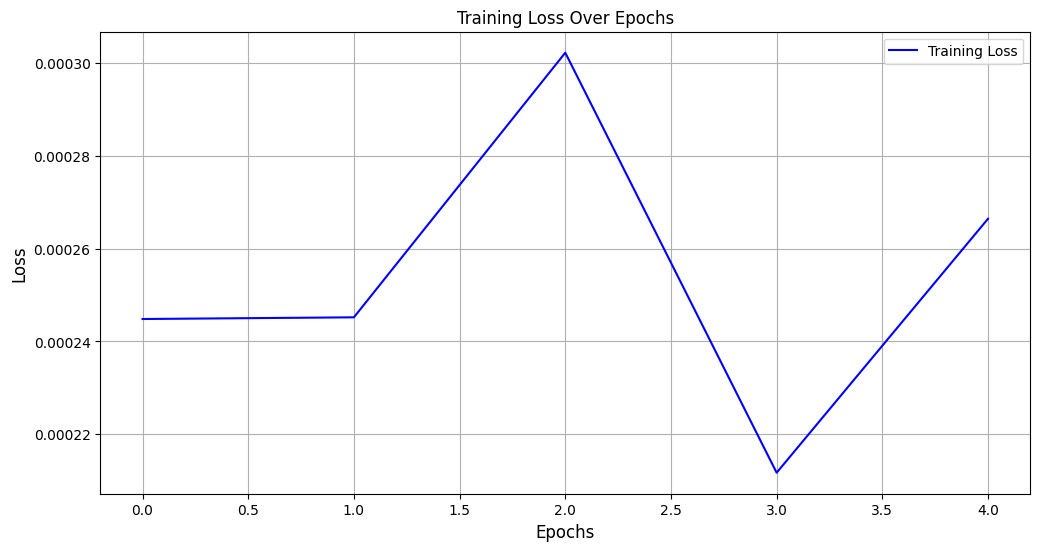

In [20]:
# Visualize Training Loss
history = model.fit(x_train, y_train, batch_size=32, epochs=50, callbacks=[early_stopping], verbose=0)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid()
plt.show()



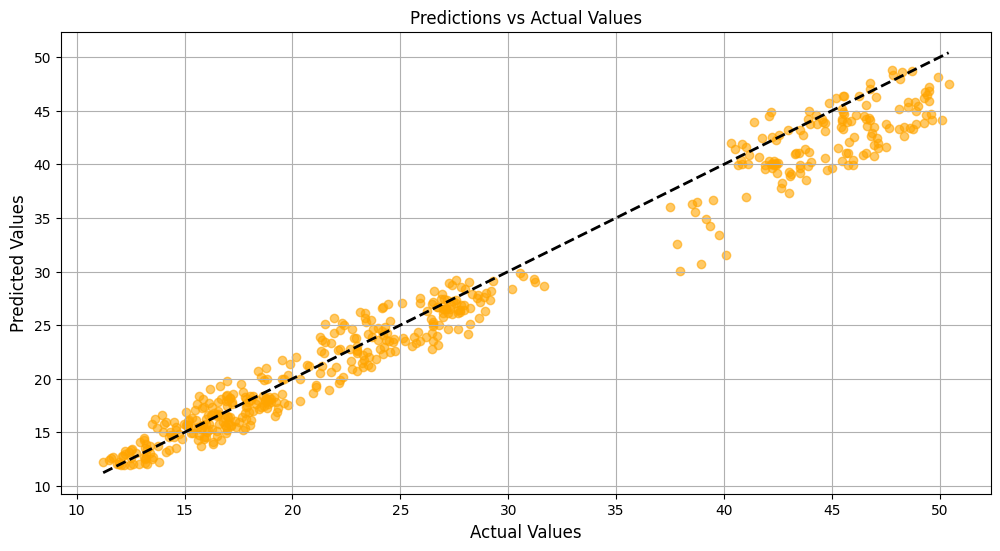

In [21]:
# Scatter Plot for Predictions vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.grid()
plt.show()


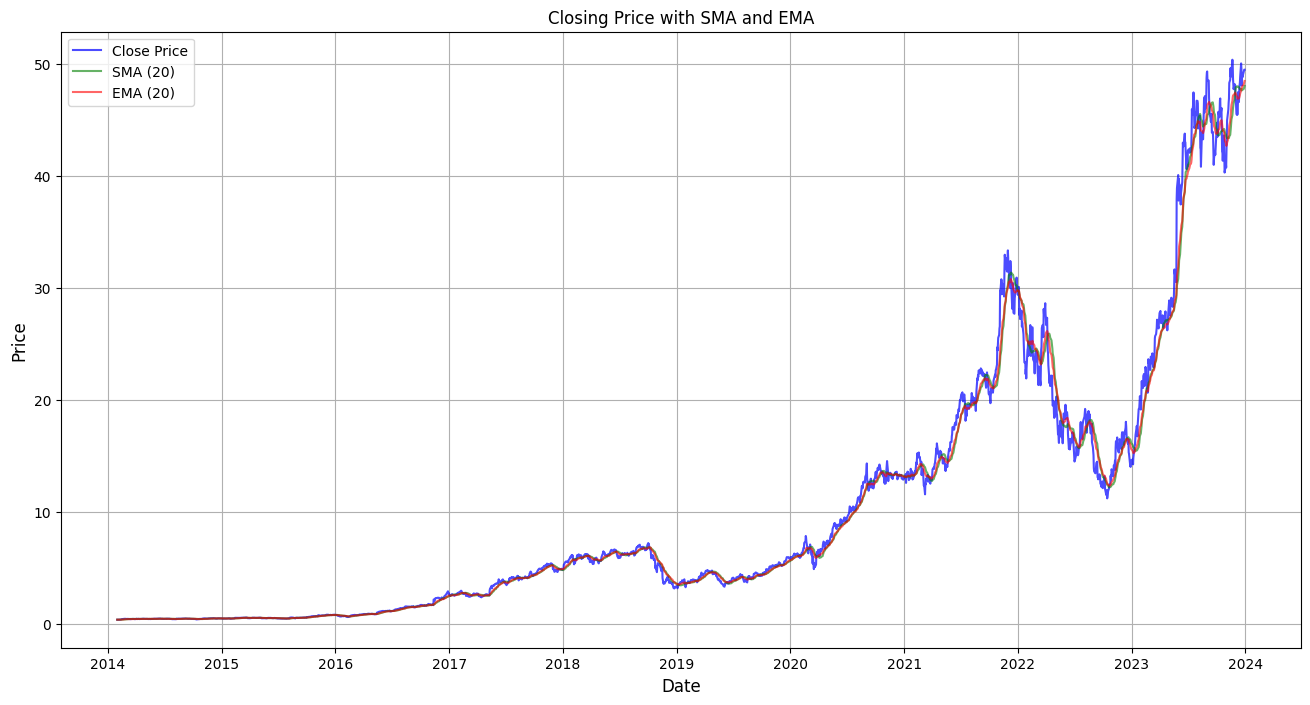

In [22]:
# Closing Price with SMA and EMA
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Close'], label='Close Price', color='blue', alpha=0.7)
plt.plot(df.index, df['SMA_20'], label='SMA (20)', color='green', alpha=0.6)
plt.plot(df.index, df['EMA_20'], label='EMA (20)', color='red', alpha=0.6)
plt.title('Closing Price with SMA and EMA')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid()
plt.show()


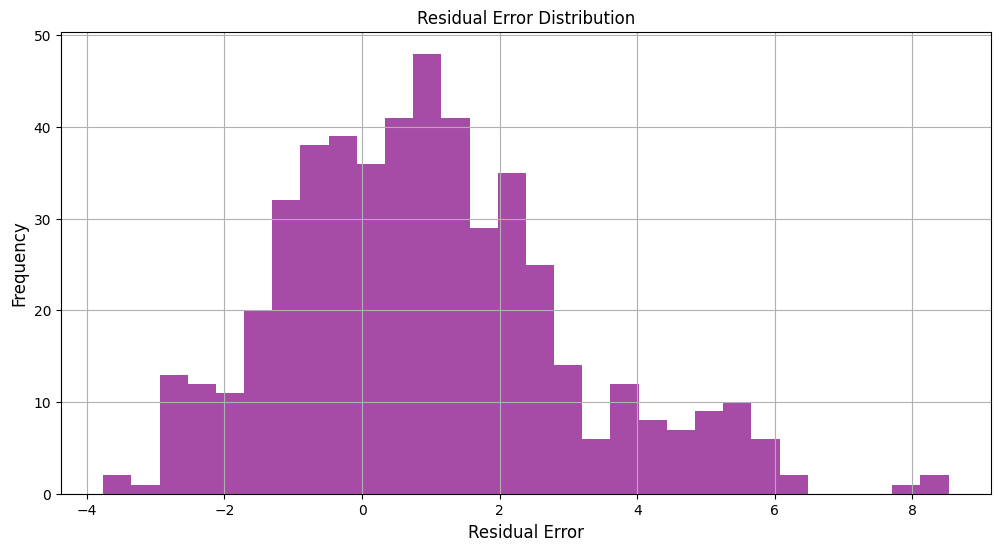

In [23]:
# Residual Errors
residuals = y_test - predictions
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='purple', alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residual Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid()
plt.show()


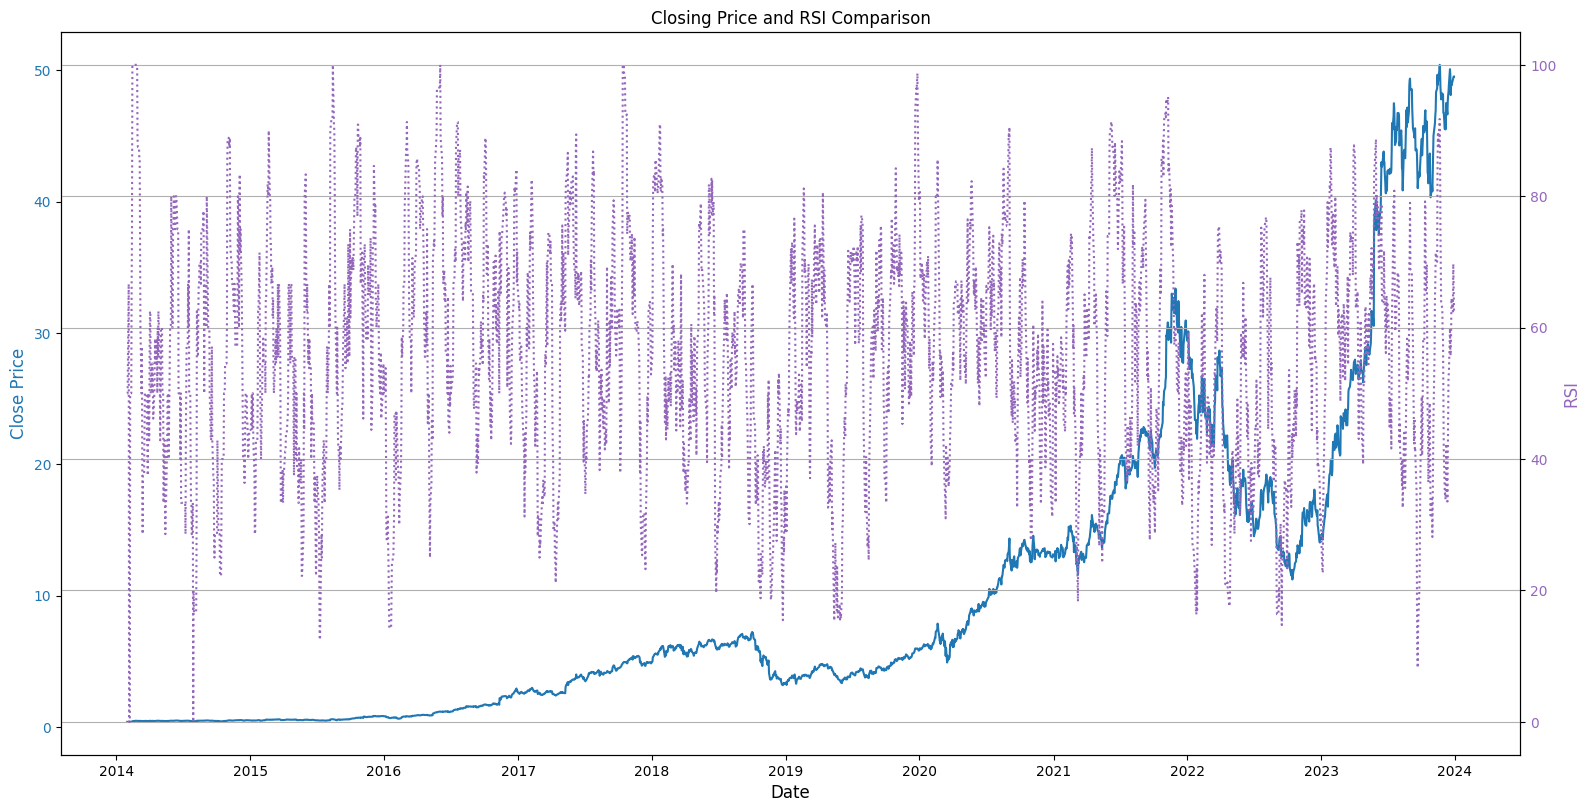

In [24]:
# RSI and Closing Price Comparison
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Close Price', color=color, fontsize=12)
ax1.plot(df.index, df['Close'], label='Close Price', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('RSI', color=color, fontsize=12)
ax2.plot(df.index, df['RSI'], label='RSI', color=color, linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Closing Price and RSI Comparison')
plt.grid()
plt.show()
